In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import (ball)
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
# from quantimpy import morphology as mp
# from quantimpy import minkowski as mk
from dataclasses import dataclass, field
from ripser import Rips
from persim import plot_diagrams

import cv2 as cv
import os
import argparse
import math
import time
import zlib
import base64
import io 
import datetime

from tkinter import *
from tkinter import Label, Tk, Button,ttk
from PIL import ImageTk,Image

from joblib import Parallel, delayed
import pandas as pd
import random
import warnings
import random

In [56]:
def filtered_img(img, k, p, otladka):    
    #Считывание размера изображения.
    h_img = img.shape[0]
    w_img = img.shape[1]

    #-------------------Рассчёт распределения серости-----------------------
    w = np.zeros(256,dtype=float)

    # Узнаём сколько каждого уровня интенсивности на изображении.
    for x in range(h_img):
        for y in range(w_img):
            w[min(255,img[x,y])] += 1

    # print(w)

    #Построение графика количества интенсивностей.
            
    if otladka == 1:
        plt.plot(w)
        plt.title('White balance id = ' + str(id))
        # plt.savefig('White balance id = ' + str(id) + '.png')
        plt.show()

    #Установка уровня объединения пикселей в группы.

    percent_level = 2       # Процент от площади изображения, которе могут занимать пиксели определённой интенсивности.
    zero_level = 0          # Порог отсечения снизу.

    # Создание маски цветов, для перекраски изображения.

    w_percent_level = h_img * w_img * percent_level / 100
    #print(w_percent_level)
    w_buf = 0
    marker = 0
    num_marker = 0
    color_maska = np.zeros(256,dtype=int)
    for n in range(256):
        w_buf = w_buf + w[n]
        if w_buf > w_percent_level:
            w_buf = 0
            if(n > zero_level):
                #print(n)
                marker = n
                num_marker += 1
        color_maska[n] = marker  

    # print(num_marker)
    # print(color_maska)

    #Построение графика уровней интенсивностей.
    if otladka == 1:
        plt.plot(color_maska)
        plt.xlim(0, 255)
        plt.ylim(0, 255)
        plt.title('Levels id = ' + str(id) + ', count = ' + str(num_marker))
        # plt.savefig('Levels id = ' + str(id) + '.png')
        plt.show()

    # Перекраска изображения.

    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            img[x,y] = color_maska[img[x,y]]

    #-----------------------Фильтр жизни---------------------------
    
    # k - Размер окна. Практика показала, что 3 мало, 7 много или как минимум не так эффективно, как 5.
    # p - Количество пикселей рассматриваемого типа в заданной зоне. Чем больше значение, тем более разделено на монотонные области финишное изображение. Для окна 5 оптимально 3. Для окна 7 оптимально 5. Для окна 3 не существует.
    dk = (k-1)//2
    mask_LS = np.zeros([img.shape[0],img.shape[1]], dtype = np.uint8)           # Маска того, что надо удалить.

    # Создание списка уровней интенсивностей.
    level = []
    old_color = -1
    for i in range(256):
        if color_maska[i] > old_color:
            # print(i, color_maska[i])
            level.append(i)
            old_color = color_maska[i]

    # print(level)
    
    # Рассмотрение каждого уровня интенсивности изображения.
    for i in level:
        count = 0
        count_old = 0
        mask = np.zeros([img.shape[0],img.shape[1]], dtype = np.uint8)          # Маска интенсивности.
        mask_L = np.zeros([img.shape[0],img.shape[1]], dtype = np.uint8)        # Маска того, что нужно удалить рассматриваемой интенсивности.

        coord_test_point_mask_x = []
        coord_test_point_mask_y = []

        # Создание маски рассматриваемой интенсивности.
        for x in range(mask.shape[0]):
            for y in range(mask.shape[1]):
                if img[x,y] == i:
                    mask[x,y] = 1

        # Первое применение фильтра жизни и создание списка пикселей для последующего рассмотрения.
        for x in range(dk,mask.shape[0]-dk):
            for y in range(dk,mask.shape[1]-dk):
                # Проверка пикселя на принодлежность маски и на условие жизни.
                if np.sum(mask[x-dk:x+dk,y-dk:y+dk]) < p and mask[x,y] == 1:
                    mask_L[x,y] = 1
                    count += 4
                    coord_test_point_mask_x.append(x+1)
                    coord_test_point_mask_y.append(y)
                    coord_test_point_mask_x.append(x-1)
                    coord_test_point_mask_y.append(y)
                    coord_test_point_mask_x.append(x)
                    coord_test_point_mask_y.append(y+1)
                    coord_test_point_mask_x.append(x)
                    coord_test_point_mask_y.append(y-1)

        # Применение фильра жизни для последующих пикселей.
        while(count_old < count):

            x = coord_test_point_mask_x[count_old]
            y = coord_test_point_mask_y[count_old]
            # print(x,y)

            # Смерть о край изображения.
            if x < 2 or x > mask_L.shape[0] - 2 or y < 2 or y > mask_L.shape[1] - 2:
                count_old +=1
                continue
                
            # Смерть по критерию жизни.
            if np.sum(mask[x-dk:x+dk,y-dk:y+dk]) < p and mask_L[x,y] != 1 and mask[x,y] == 1:
                mask_L[x,y] = 1

                # Пока нет адекватного критерия остановки по сути фильтр применяется 2 цикла. 
                # Если раскоментить строчки ниже, то рекомендуется понизить параметр p.

                # count += 4
                # coord_test_point_mask_x.append(max(x-1, 0))
                # coord_test_point_mask_y.append(y)
                # coord_test_point_mask_x.append(x)
                # coord_test_point_mask_y.append(max(y-1, 0))
                # coord_test_point_mask_x.append(min(x+1, mask_L.shape[0]))
                # coord_test_point_mask_y.append(y)
                # coord_test_point_mask_x.append(x)
                # coord_test_point_mask_y.append(min(y-1, mask_L.shape[1]))

            count_old += 1

        mask_LS[:,:] += mask_L[:,:]

        if otladka == 1:
            # cv.imwrite('C:/cv/Rock_analys/'+str(dk)+'_'+str(p)+'0_mask_'+str(i)+'.png',mask*255)
            plt.title("mask " + str(i))
            plt.imshow(mask)
            plt.gray()
            plt.show()

            # # cv.imwrite('C:/cv/Rock_analys/'+str(dk)+'_'+str(p)+'0_mask_'+str(i)+'_L.png',mask_L*255)
            plt.title("mask_L " + str(i))
            plt.imshow(mask_L)
            plt.gray()
            plt.show()

        # print(count)

    if otladka == 1:
        cv.imwrite(os.getcwd() + '/0_mask_LS'+str(dk)+'_'+str(p)+'.png',mask_LS*255)
        plt.title("mask_LS")
        plt.imshow(mask_LS)
        plt.gray()
        plt.show()

    # Нормирование маски. Почему-то встречались проблемы.
    for x in range(mask_LS.shape[0]):
        for y in range(mask_LS.shape[1]):
            if mask_LS[x,y] > 1 or img[x,y] == 255:
                mask_LS[x,y] = 1

    # Создание маски того, что мы оставляем.
    mask_ULS = np.zeros([img.shape[0],img.shape[1]], dtype = np.uint8)

    for x in range(mask_ULS.shape[0]):
        for y in range(mask_ULS.shape[1]):
            if mask_LS[x,y] != 1:
                mask_ULS[x,y] = 1

    if otladka == 1:
        cv.imwrite(os.getcwd() + '/0_mask_ULS'+str(dk)+'_'+str(p)+'.png',mask_ULS*255)
        plt.title("mask_ULS")
        plt.imshow(mask_ULS)
        plt.gray()
        plt.show()

    # Применение маски выше на изображение.
    img_with_mask_ULS = np.zeros([img.shape[0],img.shape[1]], dtype = np.uint8)

    for x in range(mask_ULS.shape[0]):
        for y in range(mask_ULS.shape[1]):
            if mask_ULS[x,y] != 1:
                img_with_mask_ULS[x,y] = 0
            else:
                img_with_mask_ULS[x,y] = img[x,y]

    if otladka == 1:
        cv.imwrite(os.getcwd() + '/3_img_with_mask_ULS.png',img_with_mask_ULS)
        plt.title("img_with_mask_ULS")
        plt.imshow(img_with_mask_ULS)
        plt.gray()
        plt.show()

    # Заполение изображения не изменяемыми пикселями.
    img_new = np.zeros([mask_ULS.shape[0],mask_ULS.shape[1]], dtype = np.uint8)

    for x in range(mask_ULS.shape[0]):
        for y in range(mask_ULS.shape[1]):
            img_new[x,y] = img_with_mask_ULS[x,y]

    if otladka == 1:
        plt.title("new_img")
        plt.imshow(img_new)
        plt.gray()
        plt.show()

    # Задание маски для волновой реконструкции изображения.
    mask_reconstruct = np.zeros([mask_ULS.shape[0],mask_ULS.shape[1]], dtype = np.uint8)
    for x in range(mask_ULS.shape[0]):
        for y in range(mask_ULS.shape[1]):
            mask_reconstruct[x,y] = mask_LS[x,y]

    if otladka == 1:
        plt.title("mask_reconstruct")
        plt.imshow(mask_reconstruct)
        plt.gray()
        plt.show()

    # Волновая реконструкция изображения.
    # 
    # Каждую область из тех, где мы не определились с цветом мы заполням послойно, как луковицу, 
    # используя среднее значение соседних определённых пикселей, если их 4 или больше.
    count = 1
    mask_reconstruct_step = np.zeros([mask_ULS.shape[0],mask_ULS.shape[1]], dtype = np.uint8)

    while count > 0:
        count = 0
        count_all = 0

        # Узнаём какие пиксили востанавливаем в этой волне.
        for x in range(mask_ULS.shape[0]):
            for y in range(mask_ULS.shape[1]):
                if mask_reconstruct[x,y] == 1:
                    count_all += 1
                    if np.sum(mask_reconstruct[x-1:x+2,y-1:y+2]) < 6:
                        mask_reconstruct_step[x,y] = 1
                        
        # Рассчёт интенсивности пикселя исходя из его соседей
        for x in range(mask_ULS.shape[0]):
            for y in range(mask_ULS.shape[1]):
                if mask_reconstruct_step[x,y] == 1:
                    img_new[x,y] = np.sum(img_new[x-1:x+2,y-1:y+2])//(9-np.sum(mask_reconstruct[x-1:x+2,y-1:y+2]))
                    mask_reconstruct[x,y] = 0
                    mask_reconstruct_step[x,y] = 0
                    count += 1

        # print(count, count_all)

    if otladka == 1:
        cv.imwrite(os.getcwd() + '/4_img_new'+str(dk)+'_'+str(p)+'.png',img_new)
        plt.title("img_new")
        plt.imshow(img_new)
        plt.gray()
        plt.show()

    # Применение медианного фильтра для сглаживания изображения
    img_new = cv.medianBlur(img_new,5)

    if otladka == 1:
        cv.imwrite(os.getcwd() + '/4_img_new_gaus_'+str(dk)+'_'+str(p)+'.png',img_new)
        plt.title("img_new_gaus")
        plt.imshow(img_new)
        plt.gray()
        plt.show()

    return img_new

In [3]:
def SRAD(img, iterationMaxStep, timeSize, decayFactor):

    # # function despeckledImg = MySRAD(img, iterationMaxStep, threshodConvergence, timeSize, decayFactor)
    # # Algorithm: Speckle Reducing Anisotropic Diffusion Method
    # # Input:
    # #   - img: the input image with speckle noise; data type [any kinds of], size N*M  
    # #   - interationMaxStep: the maximum iterative step; data type [integer(>0)]
    # #   - thresholdCovergence: the second ending rule for iteration; data type
    # #   [undefine]
    # #   - timeSize: the time step in each iteration; data type [float or
    # #   integer], scalar
    # #   - dacayFactor: the decay factor for the exp function related to
    # #   "smoothing and edge preserving"; data type [float, integer]. scalar

    # # Output:
    # #   - despeckledImg: the despeckled image; data type [same as the img], size
    # #   N*M

    # #
    # # INPUT PARAMETERS
    # #
    spatialSize = 1 ##spatial step size
    t = 0 ## starting timestap
    thresholdDiffusion = 0.0001 ## threshold for diffusion coefficient to guarantee the lower vaule (equals 0)
    thresholdConvergence = 10**(-13) ## one of the iteration determination conditions
    ROW, COL = img.shape ## input image size
    epsilon = 10**(-13) ## handle 0/0 case 

    iterationNumber = 0 ## variable of iterating step
    diviationConvergence = 1 ## the convergence diviation each iteration
   
    originalClass = type(img)

    img = img.astype('float32')
    #img = np.genfromtxt('test.txt', delimiter=',')
    

    img_i_j_ = img
    temp = img_i_j_[::spatialSize, :]
    img_i_j =temp[:,::spatialSize]
    
    ##   # translate one row (add + spatialSize)
    # #     img_ia1_j_ = [img; img((end-spatialSize+1) :end,:)];
    # #     img_ia1_j_(1:spatialSize,:) = [];
    # #     temp = img_ia1_j_(1:spatialSize:end,:);
    # #     img_ia1_j = temp(:,1:spatialSize:end);
    
    img_ia1_j = np.vstack((img_i_j, img_i_j[-1,:]))
    img_ia1_j = img_ia1_j[1:,:]
    
    ##     # translate one row (subtraction - spatialSize)
    # #     img_is1_j_ = [img(1:spatialSize,:); img];
    # #     img_is1_j_((end-spatialSize+1):end,:) = [];
    # #     temp = img_is1_j_(1:spatialSize:end, :);
    # #     img_is1_j = temp(:, 1:spatialSize:end);
    
    img_is1_j = np.vstack((img_i_j[0,:], img_i_j))
    img_is1_j = img_is1_j[:-1,:]

    ##     # translate one col (add + spatialSize)
    # #     img_i_ja1_ = [img img(:, (end-spatialSize+1):end)];
    # #     img_i_ja1_(:,1:spatialSize) = [];
    # #     temp = img_i_ja1_(1:spatialSize:end, :);
    # #     img_i_ja1 = temp(:, 1:spatialSize:end);
    
    img_i_ja1 = np.column_stack((img_i_j, img_i_j[:,-1]))
    img_i_ja1 = img_i_ja1[:,1:]
    
    
    #     # translate one col (subtraction - spatialSize)
    # #     img_i_js1_ = [img(:,1:spatialSize) img];
    # #     img_i_js1_(:,(end-spatialSize+1):end) = [];
    # #     temp = img_i_js1_(1:spatialSize:end, :);
    # #     img_i_js1 = temp(:, 1:spatialSize:end);
    
    img_i_js1 = np.column_stack((img_i_j[:,0], img_i_j))
    img_i_js1 = img_i_js1[:,:-1]

    ## #
    # # STEP1: compute derivative approximation and Laplacian approximation
    # #
    deltaR1Img = (img_ia1_j - img_i_j)/spatialSize
    deltaR2Img = (img_i_ja1 - img_i_j)/spatialSize
    
    deltaL1Img = (img_i_j - img_is1_j)/spatialSize
    deltaL2Img = (img_i_j - img_i_js1)/spatialSize
  
    delta2Img = (img_ia1_j + img_is1_j + img_i_ja1 + img_i_js1 - 4*img_i_j)/(spatialSize*spatialSize)

    ## #
    # # STEP2: caculate the diffusion coefficient
    # #
    
    ## normalizing the gradient of each image point
    gradientTotal = np.sqrt( np.multiply(deltaR1Img,deltaR1Img) + np.multiply(deltaR2Img,deltaR2Img) + np.multiply(deltaL1Img,deltaL1Img) + np.multiply(deltaL2Img,deltaL2Img) )
    deltaImgNormal = np.divide(gradientTotal,(img_i_j + epsilon))
    
    ## normalizing the Laplacian of each imge point
    delta2ImgNormal = np.divide(delta2Img,(img_i_j+epsilon))
    
    ## # compute the initial Q
    temp1 = np.multiply(deltaImgNormal,deltaImgNormal)*0.5 - np.multiply(delta2ImgNormal,delta2ImgNormal)/16
    temp2 = 1+0.25*delta2ImgNormal
    temp3 = np.multiply(temp2,temp2)
        
    q = np.sqrt(np.divide(temp1,temp3))
    Q = q
    
    #IDK# Q_0 = logical(Q)
    Q_0 = Q != 0
    #IDK# Q_0 = single(Q_0)
    Q_0 = Q_0.astype('float32')

    Img_i_j = img_i_j
    

####

    while iterationNumber <= iterationMaxStep:
        img_i_j = Img_i_j

        # # translate one row (add + spatialSize)
        img_ia1_j = np.vstack((img_i_j, img_i_j[-1,:]))
        img_ia1_j = img_ia1_j[1:,:]
        
        # # translate one row (subtraction - spatialSize)
        img_is1_j = np.vstack((img_i_j[0,:], img_i_j))
        img_is1_j = img_is1_j[:-1,:]
        

        # # translate one col (add + spatialSize)
        img_i_ja1 = np.column_stack((img_i_j, img_i_j[:,-1]))
        img_i_ja1 = img_i_ja1[:,1:]
        
        
        # # translate one col (subtraction - spatialSize)    
        img_i_js1 = np.column_stack((img_i_j[:,0], img_i_j))
        img_i_js1 = img_i_js1[:,:-1]
        
        # #
        # # STEP1: compute derivative approximation and Laplacian approximation
        # #
        deltaR1Img = (img_ia1_j - img_i_j)/spatialSize
        deltaR2Img = (img_i_ja1 - img_i_j)/spatialSize
        deltaL1Img = (img_i_j - img_is1_j)/spatialSize
        deltaL2Img = (img_i_j - img_i_js1)/spatialSize

        delta2Img = (img_ia1_j + img_is1_j + img_i_ja1 + img_i_js1 - 4*img_i_j)/(spatialSize*spatialSize)
        
        # #
        # # STEP2: caculate the diffusion coefficient
        # #
        
        # # normalizing the gradient of each image point
        gradientTotal = np.sqrt( np.multiply(deltaR1Img,deltaR1Img) + np.multiply(deltaR2Img,deltaR2Img) + np.multiply(deltaL1Img,deltaL1Img) + np.multiply(deltaL2Img,deltaL2Img) )
        deltaImgNormal = np.divide(gradientTotal,(img_i_j+ epsilon))
        
        # # normalizing the Laplacian of each imge point
        delta2ImgNormal = np.divide(delta2Img,(img_i_j+epsilon))
        
        # # compute the diffusion cefficient
        temp1 = np.multiply(deltaImgNormal,deltaImgNormal)*0.5 - np.multiply(delta2ImgNormal,delta2ImgNormal)/16
        temp2 = 1 + 0.25*delta2ImgNormal
        temp3 = np.multiply(temp2,temp2)
        q = np.sqrt(np.divide(temp1,temp3))
        
        
        q_0 = Q_0 * np.exp(-decayFactor*t)
        
        ## method 1: coefficientDiff(q) = 1/{1+[q(t)*q(t) - q(t=0)*q(t=0)]/[q(t=0)*q(t=0)(1+q(t=0)*q(t=0))]}
        temp4 = np.multiply(q_0,q_0)
        temp5 = np.multiply(q,q)
        ##     coefficientDiff = 1 + (temp5 - temp4)./(temp4.*(1+ temp4) + epsilon);
        ##     coefficientDiff = 1./(coefficientDiff + epsilon);
        ##     
        ## method 2: coefficientDiff(q) = exp^{-[q(t)*q(t) - q(t=0)*q(t=0)]/[q(t=0)*q(t=0)(1+q(t)*q(t))]}
        
        temp6 = np.divide( (temp5-temp4), ( np.multiply(temp4, (1+temp4) ) + epsilon) )
        coefficientDiff = np.exp(-temp6/6)
        
        # #
        # # STEP3: caculate the divergence of diffusion function
        # #
        
        coe_i_j = coefficientDiff
        
        coe_ia1_j = np.vstack((coefficientDiff, coefficientDiff[-1,:]))
        coe_ia1_j = coe_ia1_j[1:,:]
        
        coe_i_ja1 = np.column_stack((coefficientDiff, coefficientDiff[:,-1]))
        coe_i_ja1 = coe_i_ja1[:,1:]
        temp6 = np.multiply(coe_ia1_j,deltaR1Img) - np.multiply(coe_i_j,deltaL1Img) + np.multiply(coe_i_ja1,deltaR2Img) - np.multiply(coe_i_j,deltaL2Img)
        div = temp6/spatialSize

        # # STEP4: define the iteration rule
        Img_i_j = img_i_j + (timeSize/4)*div
        
        t = t + timeSize
        
        iterationNumber = iterationNumber + 1
    
    # #
    # #  STEP5: restore the image
    # #

    mask = np.ones((ROW, COL))
    spatialSize = 1
    mask[::spatialSize, ::spatialSize] = 0


    despeckledImg = img
    despeckledImg = np.multiply(img, mask)

    ROW_, COL_ = Img_i_j.shape

    for i in range(ROW_):
        for j in range(COL_): 
            despeckledImg[i*spatialSize][j*spatialSize] = Img_i_j[i][j]
        
    ## # restore the original data type
    # despeckledImg = cast(despeckledImg, originalClass);
    return despeckledImg.astype("uint8")

C:\Users\78916\AppData\Local\Temp/ipykernel_35124/301533718.py:106: RuntimeWarning: divide by zero encountered in divide
  q = np.sqrt(np.divide(temp1,temp3))
C:\Users\78916\AppData\Local\Temp/ipykernel_35124/301533718.py:165: RuntimeWarning: divide by zero encountered in divide
  q = np.sqrt(np.divide(temp1,temp3))


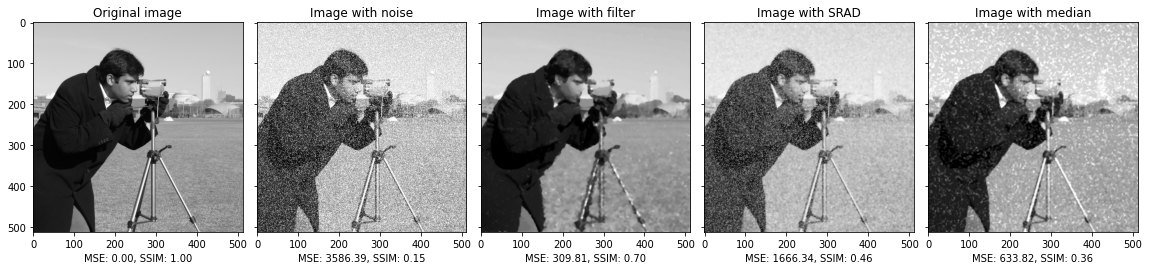

In [57]:
img = data.camera()
rows, cols = img.shape

mean = 0                                    # Среднее значение шума.
teta_n = 0.5                                # Уровень шума.
stddev = int(255 * teta_n)
noise = np.zeros(img.shape, np.uint8)
img_noise = np.zeros(img.shape, np.uint8)
cv.randn(noise, mean, stddev)
img_noise = cv.add(img, noise)

# Удаление нулевых пикселей, так как SRAD ругается.
for x in range(img.shape[0]):
    for y in range(img.shape[1]):
        if img_noise[x,y] < 1:
            img_noise[x,y] = 1

# Фильтрация фильтром с жизнью.
img_const = filtered_img(img_noise, 5, 3, 0)
img_const[0,0] = 255
img_const[0,1] = 0

# Фильтрация SRAD-ом.
iterationMaxStep, timeSize, decayFactor = 200,.05,1
img_SRAD = SRAD(img_noise, iterationMaxStep, timeSize, decayFactor)

# Медианный фильтр.
median = cv.medianBlur(img_noise,5)


fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(16, 4), sharex=True, sharey=True)
ax = axes.ravel()

mse_none = mean_squared_error(img, img)
ssim_none = ssim(img, img, data_range=img.max() - img.min())

mse_noise = mean_squared_error(img, img_noise)
ssim_noise = ssim(img, img_noise, data_range=img_noise.max() - img_noise.min())

mse_const = mean_squared_error(img, img_const)
ssim_const = ssim(img, img_const, data_range=img_const.max() - img_const.min())

mse_SRAD = mean_squared_error(img, img_SRAD)
ssim_SRAD = ssim(img, img_SRAD, data_range=img_SRAD.max() - img_SRAD.min())

mse_median = mean_squared_error(img, median)
ssim_median = ssim(img, median, data_range=median.max() - median.min())

ax[0].imshow(img, cmap=plt.cm.gray)
ax[0].set_xlabel(f'MSE: {mse_none:.2f}, SSIM: {ssim_none:.2f}')
ax[0].set_title('Original image')

ax[1].imshow(img_noise, cmap=plt.cm.gray)
ax[1].set_xlabel(f'MSE: {mse_noise:.2f}, SSIM: {ssim_noise:.2f}')
ax[1].set_title('Image with noise')

ax[2].imshow(img_const, cmap=plt.cm.gray)
ax[2].set_xlabel(f'MSE: {mse_const:.2f}, SSIM: {ssim_const:.2f}')
ax[2].set_title('Image with filter')

ax[3].imshow(img_SRAD, cmap=plt.cm.gray)
ax[3].set_xlabel(f'MSE: {mse_SRAD:.2f}, SSIM: {ssim_SRAD:.2f}')
ax[3].set_title('Image with SRAD')

ax[4].imshow(median, cmap=plt.cm.gray)
ax[4].set_xlabel(f'MSE: {mse_median:.2f}, SSIM: {ssim_median:.2f}')
ax[4].set_title('Image with median')

plt.tight_layout()
plt.show()

0/100


C:\Users\78916\AppData\Local\Temp/ipykernel_35124/301533718.py:106: RuntimeWarning: divide by zero encountered in divide
  q = np.sqrt(np.divide(temp1,temp3))
C:\Users\78916\AppData\Local\Temp/ipykernel_35124/301533718.py:165: RuntimeWarning: divide by zero encountered in divide
  q = np.sqrt(np.divide(temp1,temp3))
C:\Users\78916\AppData\Local\Temp/ipykernel_35124/301533718.py:165: RuntimeWarning: invalid value encountered in sqrt
  q = np.sqrt(np.divide(temp1,temp3))
C:\Users\78916\AppData\Local\Temp/ipykernel_35124/301533718.py:222: RuntimeWarning: invalid value encountered in cast
  return despeckledImg.astype("uint8")


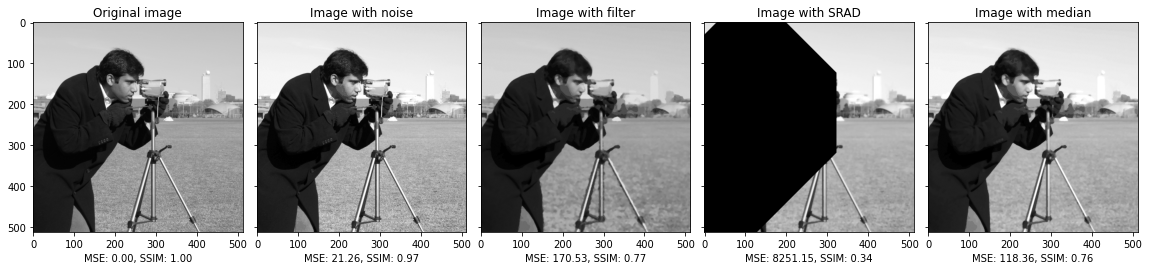

1/100
2/100
3/100
4/100
5/100
6/100
7/100
8/100
9/100
10/100


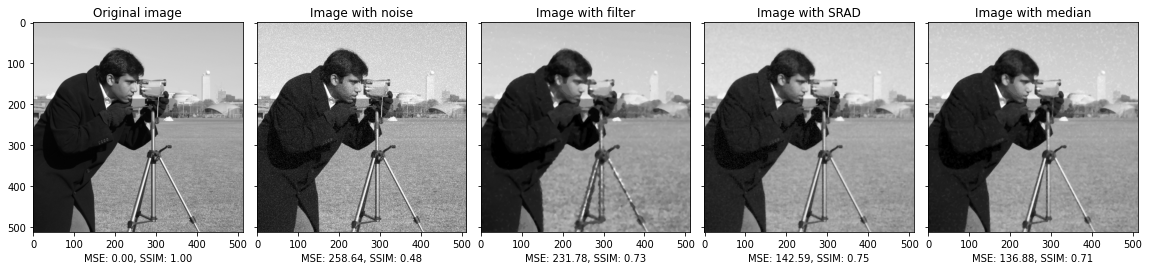

11/100
12/100
13/100
14/100
15/100
16/100
17/100
18/100
19/100
20/100


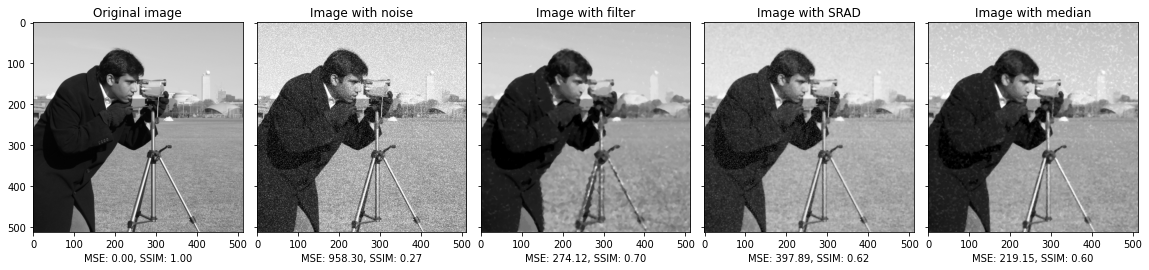

21/100
22/100
23/100
24/100
25/100
26/100
27/100
28/100
29/100
30/100


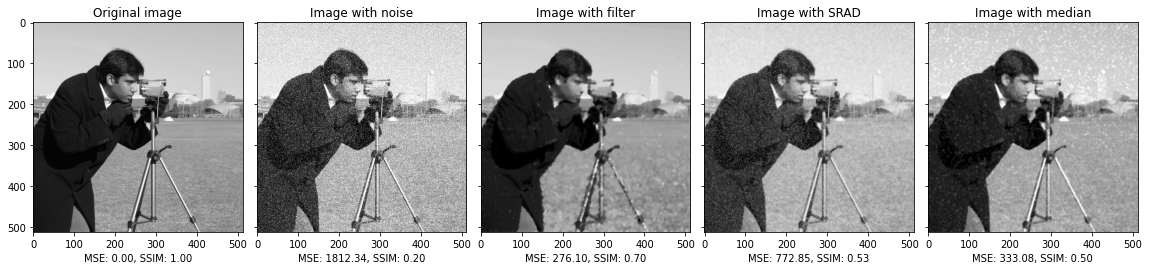

31/100
32/100
33/100
34/100
35/100
36/100
37/100
38/100
39/100
40/100


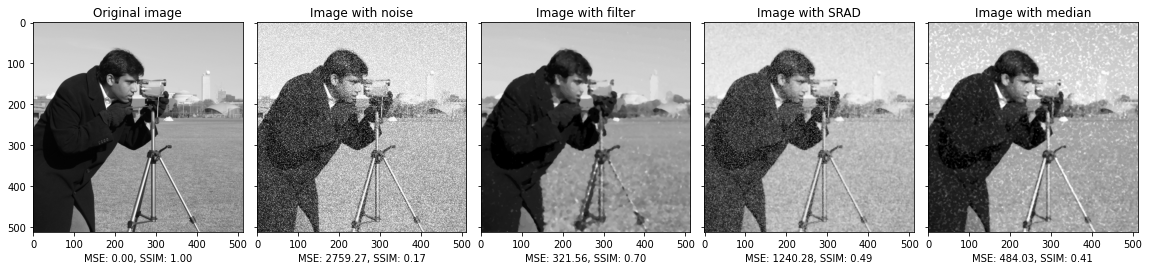

41/100
42/100
43/100
44/100
45/100
46/100
47/100
48/100
49/100
50/100


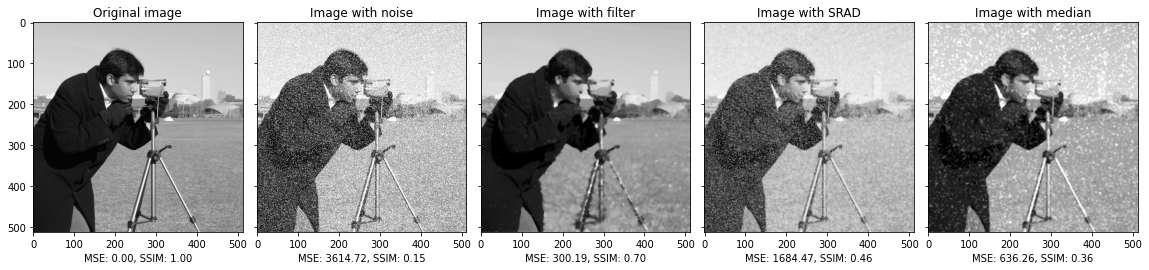

51/100
52/100
53/100
54/100
55/100
56/100
57/100
58/100
59/100
60/100


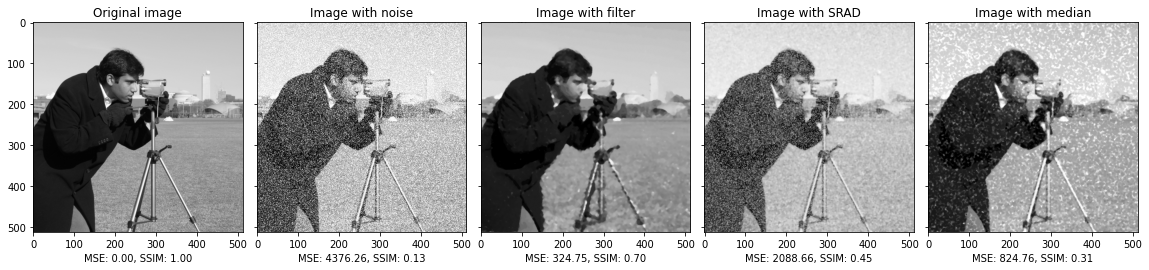

61/100
62/100
63/100
64/100
65/100
66/100
67/100
68/100
69/100
70/100


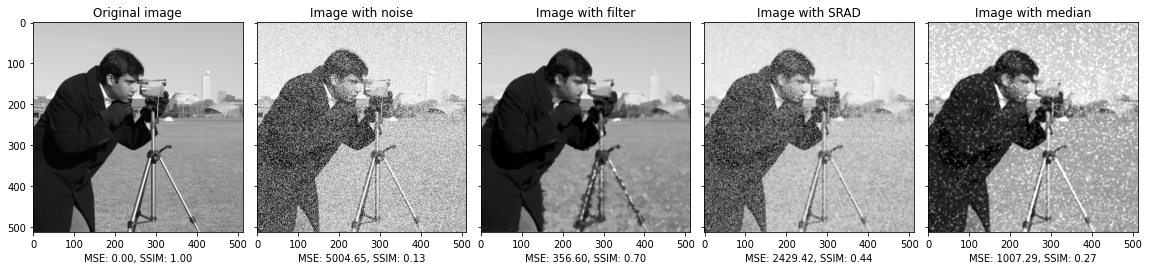

71/100
72/100
73/100
74/100
75/100
76/100
77/100
78/100
79/100
80/100


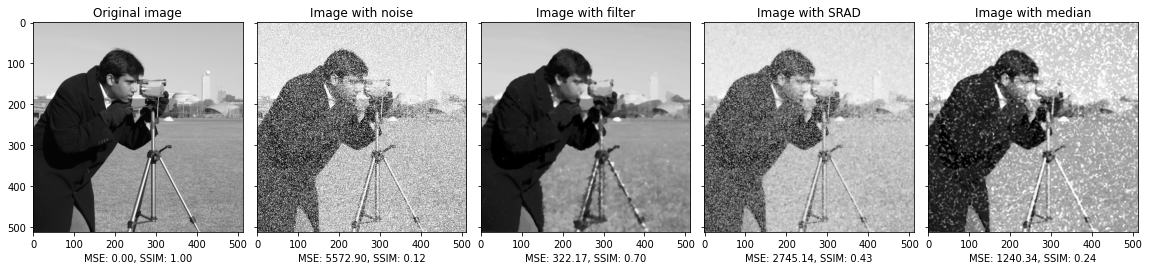

81/100
82/100
83/100
84/100
85/100
86/100
87/100
88/100
89/100
90/100


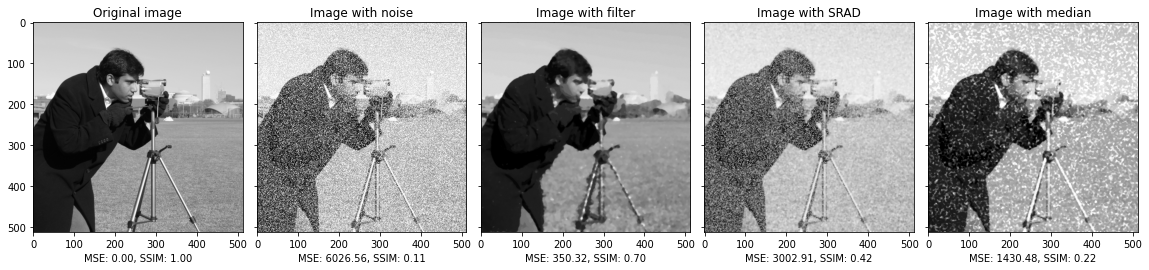

91/100
92/100
93/100
94/100
95/100
96/100
97/100
98/100
99/100


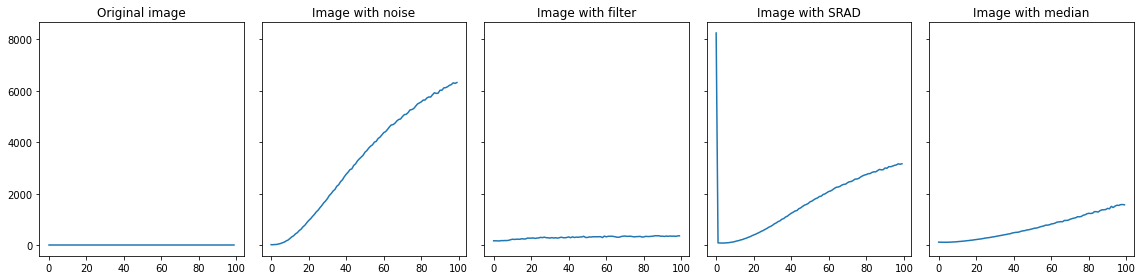

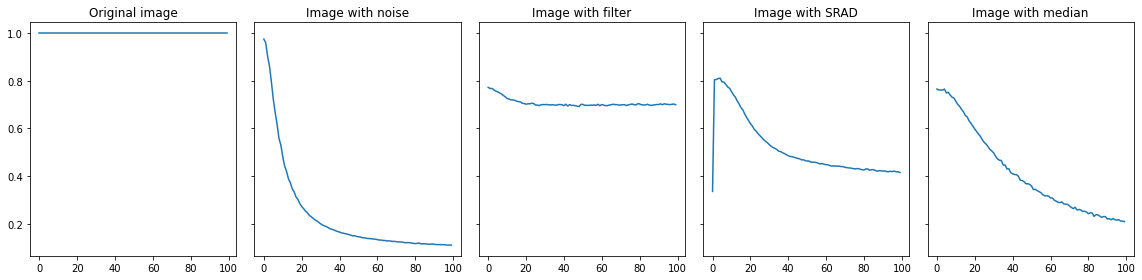

AttributeError: Line2D.set() got an unexpected keyword argument 'lable'

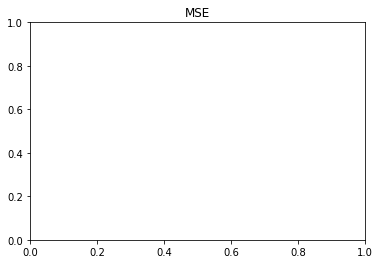

In [ ]:
img = data.camera()
rows, cols = img.shape

graf_mse_none = []
graf_ssim_none = []

graf_mse_noise = []
graf_ssim_noise = []

graf_mse_const = []
graf_ssim_const = []

graf_mse_SRAD = []
graf_ssim_SRAD = []

graf_mse_median = []
graf_ssim_median = []

for i in range(100):
    print(str(i) + '/100')
    mean = 0                                    # Среднее значение шума.
    teta_n = 0.01*i                                # Уровень шума.
    stddev = int(255 * teta_n)
    noise = np.zeros(img.shape, np.uint8)
    img_noise = np.zeros(img.shape, np.uint8)
    cv.randn(noise, mean, stddev)
    img_noise = cv.add(img, noise)

    # Удаление нулевых пикселей, так как SRAD ругается.
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if img_noise[x,y] < 1:
                img_noise[x,y] = 1

    # Фильтрация фильтром с жизнью.
    img_const = filtered_img(img_noise, 5, 3, 0)
    img_const[0,0] = 255
    img_const[0,1] = 0

    # Фильтрация SRAD-ом.
    iterationMaxStep, timeSize, decayFactor = 200,.05,1
    img_SRAD = SRAD(img_noise, iterationMaxStep, timeSize, decayFactor)

    # Медианный фильтр.
    median = cv.medianBlur(img_noise,5)

    mse_none = mean_squared_error(img, img)
    ssim_none = ssim(img, img, data_range=img.max() - img.min())
    graf_mse_none.append(mse_none)
    graf_ssim_none.append(ssim_none)

    mse_noise = mean_squared_error(img, img_noise)
    ssim_noise = ssim(img, img_noise, data_range=img_noise.max() - img_noise.min())
    graf_mse_noise.append(mse_noise)
    graf_ssim_noise.append(ssim_noise)

    mse_const = mean_squared_error(img, img_const)
    ssim_const = ssim(img, img_const, data_range=img_const.max() - img_const.min())
    graf_mse_const.append(mse_const)
    graf_ssim_const.append(ssim_const)

    mse_SRAD = mean_squared_error(img, img_SRAD)
    ssim_SRAD = ssim(img, img_SRAD, data_range=img_SRAD.max() - img_SRAD.min())
    graf_mse_SRAD.append(mse_SRAD)
    graf_ssim_SRAD.append(ssim_SRAD)

    mse_median = mean_squared_error(img, median)
    ssim_median = ssim(img, median, data_range=median.max() - median.min())
    graf_mse_median.append(mse_median)
    graf_ssim_median.append(ssim_median)

    if i % 10 == 0:
        fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(16, 4), sharex=True, sharey=True)
        ax = axes.ravel()

        ax[0].imshow(img, cmap=plt.cm.gray)
        ax[0].set_xlabel(f'MSE: {mse_none:.2f}, SSIM: {ssim_none:.2f}')
        ax[0].set_title('Original image')

        ax[1].imshow(img_noise, cmap=plt.cm.gray)
        ax[1].set_xlabel(f'MSE: {mse_noise:.2f}, SSIM: {ssim_noise:.2f}')
        ax[1].set_title('Image with noise')

        ax[2].imshow(img_const, cmap=plt.cm.gray)
        ax[2].set_xlabel(f'MSE: {mse_const:.2f}, SSIM: {ssim_const:.2f}')
        ax[2].set_title('Image with filter')

        ax[3].imshow(img_SRAD, cmap=plt.cm.gray)
        ax[3].set_xlabel(f'MSE: {mse_SRAD:.2f}, SSIM: {ssim_SRAD:.2f}')
        ax[3].set_title('Image with SRAD')

        ax[4].imshow(median, cmap=plt.cm.gray)
        ax[4].set_xlabel(f'MSE: {mse_median:.2f}, SSIM: {ssim_median:.2f}')
        ax[4].set_title('Image with median')

        plt.tight_layout()
        plt.show()

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(16, 4), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].plot(graf_mse_none)
ax[0].set_title('Original image')

ax[1].plot(graf_mse_noise)
ax[1].set_title('Image with noise')

ax[2].plot(graf_mse_const)
ax[2].set_title('Image with filter')

ax[3].plot(graf_mse_SRAD)
ax[3].set_title('Image with SRAD')

ax[4].plot(graf_mse_median)
ax[4].set_title('Image with median')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(16, 4), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].plot(graf_ssim_none)
ax[0].set_title('Original image')

ax[1].plot(graf_ssim_noise)
ax[1].set_title('Image with noise')

ax[2].plot(graf_ssim_const)
ax[2].set_title('Image with filter')

ax[3].plot(graf_ssim_SRAD)
ax[3].set_title('Image with SRAD')

ax[4].plot(graf_ssim_median)
ax[4].set_title('Image with median')

plt.tight_layout()
plt.show()

level = []
for i in range(100):
    level.append(i)

plt.title('MSE')
plt.plot(level,graf_mse_none,'b-', label  = "None")
plt.plot(level,graf_mse_noise,'r-', label  = "Noise")
plt.plot(level,graf_mse_const,'k-', label  = "Filter")
plt.plot(level,graf_mse_SRAD,'g-', label  = "SRAD")
plt.plot(level,graf_mse_median,'c-', label  = "Median")
plt.legend()
plt.show()

plt.title('SSIM')
plt.plot(level,graf_ssim_none,'b-', label  = "None")
plt.plot(level,graf_ssim_noise,'r-', label  = "Noise")
plt.plot(level,graf_ssim_const,'k-', label  = "Filter")
plt.plot(level,graf_ssim_SRAD,'g-', label  = "SRAD")
plt.plot(level,graf_ssim_median,'c-', label  = "Median")
plt.legend()
plt.show()

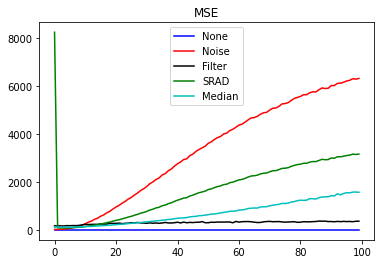

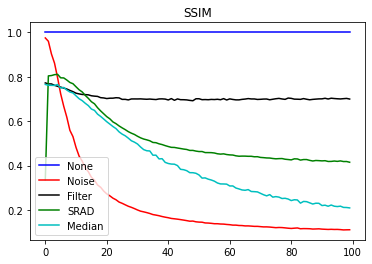

In [69]:
plt.title('MSE')
plt.plot(level,graf_mse_none,'b-', label  = "None")
plt.plot(level,graf_mse_noise,'r-', label  = "Noise")
plt.plot(level,graf_mse_const,'k-', label  = "Filter")
plt.plot(level,graf_mse_SRAD,'g-', label  = "SRAD")
plt.plot(level,graf_mse_median,'c-', label  = "Median")
plt.legend()
plt.show()

plt.title('SSIM')
plt.plot(level,graf_ssim_none,'b-', label  = "None")
plt.plot(level,graf_ssim_noise,'r-', label  = "Noise")
plt.plot(level,graf_ssim_const,'k-', label  = "Filter")
plt.plot(level,graf_ssim_SRAD,'g-', label  = "SRAD")
plt.plot(level,graf_ssim_median,'c-', label  = "Median")
plt.legend()
plt.show()